#  MACHINE LEARNING: Portugal Wine under Two Class approach for Quality classification with Logistic Regression using R and K fold cross-validation
# Module 3: Solving project with dataset dffful


By: Hector Alvaro Rojas | Data Science, Visualizations and Applied Statistics | October 25, 2017<br>
Url: [http://www.arqmain.net]   &nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;   GitHub: [https://github.com/arqmain]
<hr>

# I Introduction

We consider the original dataset without the variables "density" and "free.sulfor.dioxide".

<u><b><i>dfffull</i></b></u> keep all the register of the original database "df" but replace the upper outliers by its corresponding <i>Threshold</i>.


We consider outliers those points that have any predictor variable value to be outside of the limits constructed by boxplots. The following rule is applied:

* A predictor value is considered to be an upper outlier only if it is greater than <b>Threshold = Q3 + 1.5IQR</b>

Application of this rule oes not reduces the original datasize becouse it does not eliminate any register.  So, <i>dfffull</i></b></u> data size is the same as the original "df" 6497).

# II Loading and the Data

In [117]:
# first remove ALL objects and close all possible connections
closeAllConnections()
rm(list = ls(all = TRUE)) # Does remove all inclusive hidden

# see your memory size
memory.size() 

In [1]:
# install packages and load libraries
ipak <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = c("Depends", "Suggests"))
    sapply(pkg, require, character.only = TRUE)
}
# usage
packages <- c("plyr", "dplyr", "caret")
ipak(packages)


Loading required package: plyr
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2


plyr dplyr caret 
 TRUE  TRUE  TRUE

In [2]:
# define path location of datasets
wine1.url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
wine2.url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

# read datasets
wine1 <- read.csv(wine1.url, header=TRUE, sep=';')
wine2 <- read.csv(wine2.url, header=TRUE, sep=';')

# create dataset base
paso <- rbind(cbind(wine1, Class='white'), cbind(wine2, Class='red'))
paso$quality<- ifelse(paso$quality>=6, "Good", ifelse(paso$quality<6, "Bad", NA))

df= subset(paso, select=c('fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar', 'chlorides' ,'total.sulfur.dioxide','pH', 'sulphates', 'alcohol', 'quality', 'Class'))
attach(df)
head(df)
rm("paso", "wine1", "wine2")

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class
7.0,0.27,0.36,20.7,0.045,170,3.00,0.45,8.8,Good,white
6.3,0.30,0.34,1.6,0.049,132,3.30,0.49,9.5,Good,white
8.1,0.28,0.40,6.9,0.050,97,3.26,0.44,10.1,Good,white
7.2,0.23,0.32,8.5,0.058,186,3.19,0.40,9.9,Good,white
7.2,0.23,0.32,8.5,0.058,186,3.19,0.40,9.9,Good,white
8.1,0.28,0.40,6.9,0.050,97,3.26,0.44,10.1,Good,white


In [3]:
# verify response variable "quality" as factor
df$quality <- as.factor(df$quality)
df$Class <- as.factor(df$Class)

In [51]:
# get some information about the dataset
str(df)

'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  20.7 1.6 6.9 8.5 8.5 6.9 7 20.7 1.6 1.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : Factor w/ 2 levels "Bad","Good": 2 2 2 2 2 2 2 2 2 2 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


In [6]:
#summarize full dataset by columns 
propmiss <- function(dataframe) {
	m <- sapply(dataframe, function(x) {
		data.frame(
			n=length(!is.na(x)), 
			nmiss=sum(is.na(x)), 
			propmiss=sum(is.na(x))/length(x),
			P25=round(quantile(x, 0.25, na.rm=TRUE),2),
			P75=round(quantile(x, 0.75, na.rm=TRUE),2),            
			IQR=round(IQR(x, na.rm=TRUE),2),
			Threshold= round(quantile(x, 0.75, na.rm=TRUE),2) + 1.5*round(IQR(x, na.rm=TRUE),2),            
			Minimum=round(min(x, na.rm=TRUE),2),
			Median=round(median(x, na.rm=TRUE),2),            
			Maximum=round(max(x, na.rm=TRUE),2),
			Range=round(max(x, na.rm=TRUE)-min(x, na.rm=TRUE),2),
			Mean=round(mean(x, na.rm=TRUE),2),
			StDev=round(sd(x, na.rm=TRUE),2)
		)
	})
	d <- data.frame(t(m))
	d <- sapply(d, unlist)
	d <- as.data.frame(d)
	d$variable <- row.names(d)
	row.names(d) <- NULL
	d <- cbind(d[ncol(d)],d[-ncol(d)])
	return(d[order(d$propmiss), ])
}

In [7]:
# summarize original df dataset
(summary1=propmiss(df[,-c(10:11)])[,-(3:4)])

variable,n,P25,P75,IQR,Threshold,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,6497,6.40,7.70,1.30,9.650,3.80,7.00,15.90,12.10,7.22,1.30
volatile.acidity,6497,0.23,0.40,0.17,0.655,0.08,0.29,1.58,1.50,0.34,0.16
citric.acid,6497,0.25,0.39,0.14,0.600,0.00,0.31,1.66,1.66,0.32,0.15
residual.sugar,6497,1.80,8.10,6.30,17.550,0.60,3.00,65.80,65.20,5.44,4.76
chlorides,6497,0.04,0.06,0.03,0.105,0.01,0.05,0.61,0.60,0.06,0.04
total.sulfur.dioxide,6497,77.00,156.00,79.00,274.500,6.00,118.00,440.00,434.00,115.74,56.52
pH,6497,3.11,3.32,0.21,3.635,2.72,3.21,4.01,1.29,3.22,0.16
sulphates,6497,0.43,0.60,0.17,0.855,0.22,0.51,2.00,1.78,0.53,0.15
alcohol,6497,9.50,11.30,1.80,14.000,8.00,10.30,14.90,6.90,10.49,1.19


In [4]:
# r code to replace outliers by the threshold of each variable
library(mlr)

Loading required package: ParamHelpers

Attaching package: 'mlr'

The following object is masked from 'package:caret':

    train



In [8]:
dfffull <- capLargeValues(df, target = "Class",cols = c("fixed.acidity"),threshold = summary1[1,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("volatile.acidity"),threshold = summary1[2,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("citric.acid"),threshold = summary1[3,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("residual.sugar"),threshold = summary1[4,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("chlorides"),threshold = summary1[5,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("total.sulfur.dioxide"),threshold = summary1[6,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("pH"),threshold = summary1[7,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("sulphates"),threshold = summary1[8,6])
dfffull <- capLargeValues(dfffull, target = "Class",cols = c("alcohol"),threshold = summary1[9,6])
unloadNamespace("mlr")

In [9]:
# get some information about the dataset
str(dfffull)

'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  17.5 1.6 6.9 8.5 8.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : Factor w/ 2 levels "Bad","Good": 2 2 2 2 2 2 2 2 2 2 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


In [9]:
# remove and dettach df dataset
rm("df")
detach("df")

In [10]:
# rename dff dataset as df dataset to use the already created R scripts
df <- dfffull

# remove dff dataset
rm("dfffull")

In [12]:
head(df)
str(df)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class
7.0,0.27,0.36,17.55,0.045,170,3.00,0.45,8.8,Good,white
6.3,0.30,0.34,1.60,0.049,132,3.30,0.49,9.5,Good,white
8.1,0.28,0.40,6.90,0.050,97,3.26,0.44,10.1,Good,white
7.2,0.23,0.32,8.50,0.058,186,3.19,0.40,9.9,Good,white
7.2,0.23,0.32,8.50,0.058,186,3.19,0.40,9.9,Good,white
8.1,0.28,0.40,6.90,0.050,97,3.26,0.44,10.1,Good,white


'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  17.5 1.6 6.9 8.5 8.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : Factor w/ 2 levels "Bad","Good": 2 2 2 2 2 2 2 2 2 2 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


# III Getting train and test datasets

In [11]:
#stratified sampling to get the train and test dataset
set.seed(7) # Set Seed so that same sample can be reproduced in future also
# considering response variable as strata
data_part <- createDataPartition(y = df$quality ,  p = 0.70, list = F)
testing <- df[-data_part,] # 30% data goes here
training <- df[data_part,] # 70% here

length(training$Class)
length(testing$Class)

[1] 4549

[1] 1948

In [26]:
#taking a look of the train and test dataset by columns 
head(training)
head(testing)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class
2,6.3,0.30,0.34,1.6,0.049,132,3.30,0.49,9.5,Good,white
3,8.1,0.28,0.40,6.9,0.050,97,3.26,0.44,10.1,Good,white
4,7.2,0.23,0.32,8.5,0.058,186,3.19,0.40,9.9,Good,white
5,7.2,0.23,0.32,8.5,0.058,186,3.19,0.40,9.9,Good,white
8,7.0,0.27,0.36,20.7,0.045,170,3.00,0.45,8.8,Good,white
9,6.3,0.30,0.34,1.6,0.049,132,3.30,0.49,9.5,Good,white


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class
1,7.0,0.27,0.36,20.70,0.045,170,3.00,0.45,8.8,Good,white
6,8.1,0.28,0.40,6.90,0.050,97,3.26,0.44,10.1,Good,white
7,6.2,0.32,0.16,7.00,0.045,136,3.18,0.47,9.6,Good,white
11,8.1,0.27,0.41,1.45,0.033,63,2.99,0.56,12.0,Bad,white
12,8.6,0.23,0.40,4.20,0.035,109,3.14,0.53,9.7,Bad,white
19,7.4,0.34,0.42,1.10,0.033,171,3.12,0.53,11.3,Good,white


In [14]:
# get some information about training dataset
str(training[,1:11])

'data.frame':	4549 obs. of  11 variables:
 $ fixed.acidity       : num  6.3 8.1 7.2 7.2 7 6.3 8.1 7.9 6.6 8.3 ...
 $ volatile.acidity    : num  0.3 0.28 0.23 0.23 0.27 0.3 0.22 0.18 0.16 0.42 ...
 $ citric.acid         : num  0.34 0.4 0.32 0.32 0.36 0.34 0.43 0.37 0.4 0.6 ...
 $ residual.sugar      : num  1.6 6.9 8.5 8.5 17.5 ...
 $ chlorides           : num  0.049 0.05 0.058 0.058 0.045 0.049 0.044 0.04 0.044 0.04 ...
 $ total.sulfur.dioxide: num  132 97 186 186 170 132 129 75 143 172 ...
 $ pH                  : num  3.3 3.26 3.19 3.19 3 3.3 3.22 3.18 3.54 2.98 ...
 $ sulphates           : num  0.49 0.44 0.4 0.4 0.45 0.49 0.45 0.63 0.52 0.67 ...
 $ alcohol             : num  9.5 10.1 9.9 9.9 8.8 9.5 11 10.8 12.4 9.7 ...
 $ quality             : Factor w/ 2 levels "Bad","Good": 2 2 2 2 2 2 2 1 2 1 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


In [15]:
# get some information about testing dataset
str(testing[,1:11])

'data.frame':	1948 obs. of  11 variables:
 $ fixed.acidity       : num  7 8.1 6.2 8.1 8.6 7.4 6.5 7 7.4 8.5 ...
 $ volatile.acidity    : num  0.27 0.28 0.32 0.27 0.23 0.34 0.31 0.25 0.27 0.24 ...
 $ citric.acid         : num  0.36 0.4 0.16 0.41 0.4 0.42 0.14 0.32 0.48 0.39 ...
 $ residual.sugar      : num  17.55 6.9 7 1.45 4.2 ...
 $ chlorides           : num  0.045 0.05 0.045 0.033 0.035 0.033 0.044 0.046 0.047 0.044 ...
 $ total.sulfur.dioxide: num  170 97 136 63 109 171 133 245 132 142 ...
 $ pH                  : num  3 3.26 3.18 2.99 3.14 3.12 3.22 3.25 3.19 3.2 ...
 $ sulphates           : num  0.45 0.44 0.47 0.56 0.53 0.53 0.5 0.5 0.49 0.53 ...
 $ alcohol             : num  8.8 10.1 9.6 12 9.7 11.3 9.5 10.4 11.6 10 ...
 $ quality             : Factor w/ 2 levels "Bad","Good": 2 2 2 1 1 2 1 2 2 2 ...
 $ Class               : Factor w/ 2 levels "white","red": 1 1 1 1 1 1 1 1 1 1 ...


In [16]:
# summarize training dataset
(summary=propmiss(training[,-c(10:11)])[,-(3:4)][,-6])

variable,n,P25,P75,IQR,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,4549,6.40,7.70,1.30,3.80,7.00,9.65,5.85,7.15,1.07
volatile.acidity,4549,0.23,0.41,0.18,0.08,0.29,0.66,0.58,0.33,0.15
citric.acid,4549,0.25,0.39,0.14,0.00,0.31,0.60,0.60,0.31,0.13
residual.sugar,4549,1.80,8.00,6.20,0.60,2.90,17.55,16.95,5.35,4.59
chlorides,4549,0.04,0.06,0.03,0.01,0.05,0.10,0.09,0.05,0.02
total.sulfur.dioxide,4549,77.00,156.00,79.00,6.00,118.00,274.50,268.50,115.52,56.70
pH,4549,3.11,3.32,0.21,2.72,3.21,3.63,0.91,3.22,0.16
sulphates,4549,0.43,0.60,0.17,0.25,0.51,0.86,0.60,0.53,0.13
alcohol,4549,9.50,11.30,1.80,8.00,10.40,14.00,6.00,10.51,1.19


In [17]:
# summarize testing dataset
(summary=propmiss(testing[,-c(10:11)])[,-(3:4)][,-6])

variable,n,P25,P75,IQR,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,1948,6.40,7.70,1.30,4.40,7.00,9.65,5.25,7.13,1.06
volatile.acidity,1948,0.23,0.40,0.17,0.08,0.29,0.66,0.58,0.33,0.14
citric.acid,1948,0.24,0.39,0.15,0.00,0.31,0.60,0.60,0.32,0.14
residual.sugar,1948,1.80,8.30,6.50,0.70,3.30,17.55,16.85,5.55,4.66
chlorides,1948,0.04,0.06,0.03,0.01,0.05,0.10,0.10,0.05,0.02
total.sulfur.dioxide,1948,78.00,155.00,77.00,6.00,119.00,274.50,268.50,116.02,55.23
pH,1948,3.11,3.31,0.20,2.74,3.20,3.63,0.89,3.22,0.15
sulphates,1948,0.43,0.59,0.16,0.22,0.50,0.86,0.64,0.52,0.13
alcohol,1948,9.50,11.30,1.80,8.40,10.20,14.00,5.60,10.45,1.19


# IV Logistic Regression
 
In this project I have considered Logistic Regression algorithm. I use "set.seed(7)" so that same sample can be reproduced in the future and also it ensures the results are directly comparable.

## 41 Building Machine Learning Model

### 411 Find model equation 

In [16]:
## modelo completo
set.seed(7)
model1<- glm(quality ~ ., data=training, family="binomial")
summary(model1)


Call:
glm(formula = quality ~ ., family = "binomial", data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1391  -0.8884   0.4244   0.8147   2.2726  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -8.273492   1.188135  -6.963 3.32e-12 ***
fixed.acidity        -0.094141   0.047391  -1.986  0.04698 *  
volatile.acidity     -5.696527   0.391809 -14.539  < 2e-16 ***
citric.acid          -0.407946   0.327890  -1.244  0.21344    
residual.sugar        0.060909   0.009333   6.526 6.73e-11 ***
chlorides            -5.086168   2.711614  -1.876  0.06070 .  
total.sulfur.dioxide -0.002056   0.001032  -1.993  0.04627 *  
pH                    0.053819   0.286055   0.188  0.85076    
sulphates             2.224594   0.354080   6.283 3.33e-10 ***
alcohol               0.990151   0.045830  21.605  < 2e-16 ***
Classred              0.683281   0.213763   3.196  0.00139 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01

In [13]:
# best model Stepwise backward-AIC
model2<- step(glm(quality ~ ., family = binomial(link = "logit"), data=training), trace= F, direction="backward")
summary(model2)


Call:
glm(formula = quality ~ fixed.acidity + volatile.acidity + residual.sugar + 
    chlorides + total.sulfur.dioxide + sulphates + alcohol + 
    Class, family = binomial(link = "logit"), data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1558  -0.8875   0.4230   0.8136   2.2720  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -7.993687   0.644156 -12.410  < 2e-16 ***
fixed.acidity        -0.121557   0.038912  -3.124 0.001785 ** 
volatile.acidity     -5.535149   0.369428 -14.983  < 2e-16 ***
residual.sugar        0.060006   0.009228   6.503 7.89e-11 ***
chlorides            -5.441662   2.690726  -2.022 0.043137 *  
total.sulfur.dioxide -0.002152   0.001021  -2.107 0.035109 *  
sulphates             2.181291   0.346916   6.288 3.22e-10 ***
alcohol               0.986092   0.045536  21.655  < 2e-16 ***
Classred              0.719525   0.203962   3.528 0.000419 ***
---
Signif. codes:  0 '***' 0.00

In [14]:
## best model Stepwise backward-BIC
model3<- step(glm(quality ~ ., family = binomial(link = "logit"), data=training), trace= F, direction="backward", k=log(nrow(training)))
summary(model3)


Call:
glm(formula = quality ~ fixed.acidity + volatile.acidity + residual.sugar + 
    sulphates + alcohol + Class, family = binomial(link = "logit"), 
    data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.2549  -0.8848   0.4224   0.8195   2.3150  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -8.953905   0.561935 -15.934  < 2e-16 ***
fixed.acidity    -0.127763   0.038785  -3.294 0.000987 ***
volatile.acidity -5.701184   0.365988 -15.578  < 2e-16 ***
residual.sugar    0.056636   0.008906   6.360 2.02e-10 ***
sulphates         2.013965   0.340206   5.920 3.22e-09 ***
alcohol           1.044034   0.041592  25.102  < 2e-16 ***
Classred          0.798313   0.150720   5.297 1.18e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5979.9  on 4548  degrees of freedom
Residual deviance: 4655.2  on 4542  degrees 

As we can see, Model2 (backward-AIC) has achieved a lower AIC value (model2-AIC= 4664.1) being the best model according to the Stepwise method. Also, we can compare the models using the ANOVA test. Let's say our null hypothesis is that second model is better than the first model. p < 0.05 would reject our hypothesis and in case p > 0.05, we'll fail to reject the null hypothesis.

In [17]:
#compare the models by using anova-chisq
anova(model1,model2,test = "Chisq")
anova(model1,model3,test = "Chisq")
anova(model2,model3,test = "Chisq")


Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
4538,4644.480,NA,NA,NA
4540,4646.145,-2,-1.665102,0.4349384


Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
4538,4644.480,NA,NA,NA
4542,4655.201,-4,-10.72086,0.02988689


Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
4540,4646.145,NA,NA,NA
4542,4655.201,-2,-9.055762,0.01080355


In [18]:
#compare the models by using lrtest-chisq
library(lmtest)
lrtest(model, model2)
lrtest(model, model3)
lrtest(model2,model3)

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



#Df,LogLik,Df,Chisq,Pr(>Chisq)
11,-2322.240,NA,NA,NA
9,-2323.072,-2,1.665102,0.4349384


#Df,LogLik,Df,Chisq,Pr(>Chisq)
11,-2322.24,NA,NA,NA
7,-2327.60,-4,10.72086,0.02988689


#Df,LogLik,Df,Chisq,Pr(>Chisq)
9,-2323.072,NA,NA,NA
7,-2327.600,-2,9.055762,0.01080355


With p > 0.05, both test (ANOVA and LRTEST) also corroborates the fact that the second model (model2) is the best model according to the Stepwise method. So, we will keep model2 and we will evaluate its performance as a supervised machine learning model.

### 412 Building the model 

In [19]:
## Control Resampling Technique: 10-fold CV
fiveStats = function(...) c (twoClassSummary(...), defaultSummary(...))
cvCtrl <- trainControl(method = "cv", number=10,  summaryFunction = fiveStats, classProbs = TRUE, savePredictions=T)

In [20]:
## Construction Predictive Model
set.seed(1)
formula2 <- as.formula("quality ~ fixed.acidity + volatile.acidity + residual.sugar + chlorides + total.sulfur.dioxide + sulphates + alcohol + Class")
lrmodel2 <- train(formula2, data=training, method="glm",   family=binomial(link = "logit"), preProc = c("center", "scale"), tuneLength = 5, trControl = cvCtrl)

In [21]:
## Getting summary of fitted model2
summary(lrmodel2)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1558  -0.8875   0.4230   0.8136   2.2720  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)           0.76849    0.03865  19.882  < 2e-16 ***
fixed.acidity        -0.13015    0.04166  -3.124 0.001785 ** 
volatile.acidity     -0.80567    0.05377 -14.983  < 2e-16 ***
residual.sugar        0.27550    0.04237   6.503 7.89e-11 ***
chlorides            -0.11566    0.05719  -2.022 0.043137 *  
total.sulfur.dioxide -0.12203    0.05791  -2.107 0.035109 *  
sulphates             0.28677    0.04561   6.288 3.22e-10 ***
alcohol               1.17793    0.05440  21.655  < 2e-16 ***
Classred              0.31139    0.08827   3.528 0.000419 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5979.9  on 4548  degrees of freedom
Residual deviance: 4646.1  on 4540  degrees of freedom
AIC

In [22]:
## train results model2
lrmodel2

Generalized Linear Model 

4549 samples
   8 predictor
   2 classes: 'Bad', 'Good' 

Pre-processing: centered (8), scaled (8) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4095, 4094, 4094, 4094, 4094, 4094, ... 
Resampling results:

  ROC        Sens       Spec       Accuracy   Kappa   
  0.8054554  0.5871654  0.8451389  0.7504947  0.445908


In [23]:
## Test Set Results model2
lrPred2 <- predict(lrmodel2,testing, type="raw")
confusionMatrix(lrPred2, testing$quality, positive = "Good")

Confusion Matrix and Statistics

          Reference
Prediction  Bad Good
      Bad   409  219
      Good  306 1014
                                          
               Accuracy : 0.7305          
                 95% CI : (0.7102, 0.7501)
    No Information Rate : 0.633           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4048          
 Mcnemar's Test P-Value : 0.0001745       
                                          
            Sensitivity : 0.8224          
            Specificity : 0.5720          
         Pos Pred Value : 0.7682          
         Neg Pred Value : 0.6513          
             Prevalence : 0.6330          
         Detection Rate : 0.5205          
   Detection Prevalence : 0.6776          
      Balanced Accuracy : 0.6972          
                                          
       'Positive' Class : Good            
                                          

In [24]:
## Predicting Class Probabilities model2
lrProbs2 <- predict(lrmodel2, testing, type = "prob")
head(lrProbs2)

,Bad,Good
1,0.55910952,0.4408905
6,0.41961854,0.5803815
7,0.53604910,0.4639509
11,0.08677416,0.9132258
12,0.44127759,0.5587224
19,0.26073573,0.7392643


In [25]:
# variable importance model2
lr.imp2 = varImp (lrmodel2 , scale = F )
lr.imp2

glm variable importance

                     Overall
alcohol               21.655
volatile.acidity      14.983
residual.sugar         6.503
sulphates              6.288
Classred               3.528
fixed.acidity          3.124
total.sulfur.dioxide   2.107
chlorides              2.022

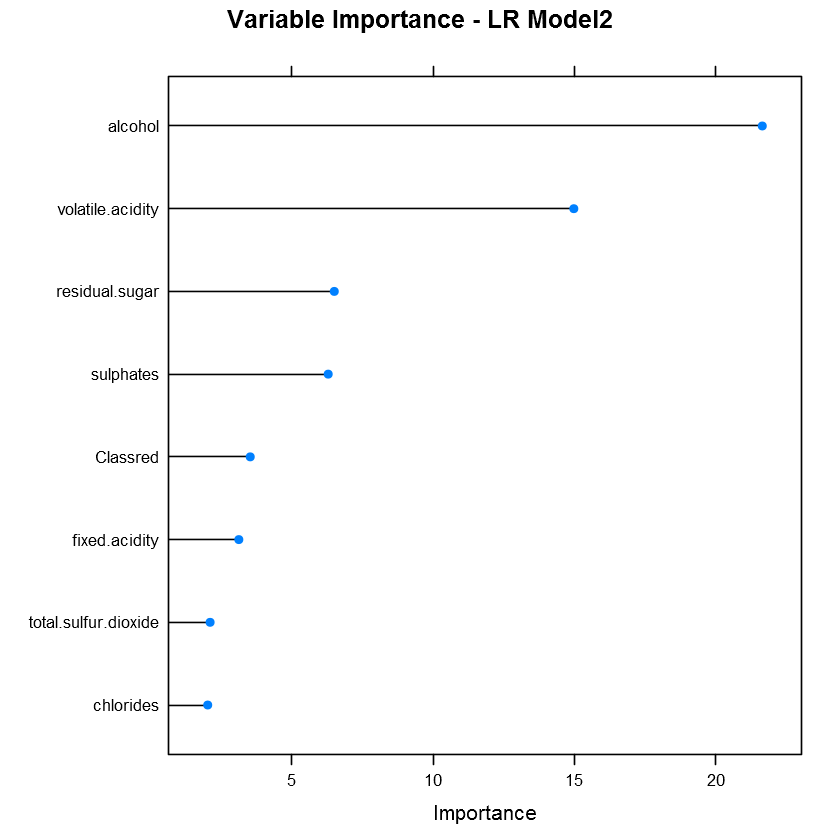

In [26]:
## Graphic variable importance model2
# dev.new()
plot(lr.imp2, top=8, main="Variable Importance - LR Model2")

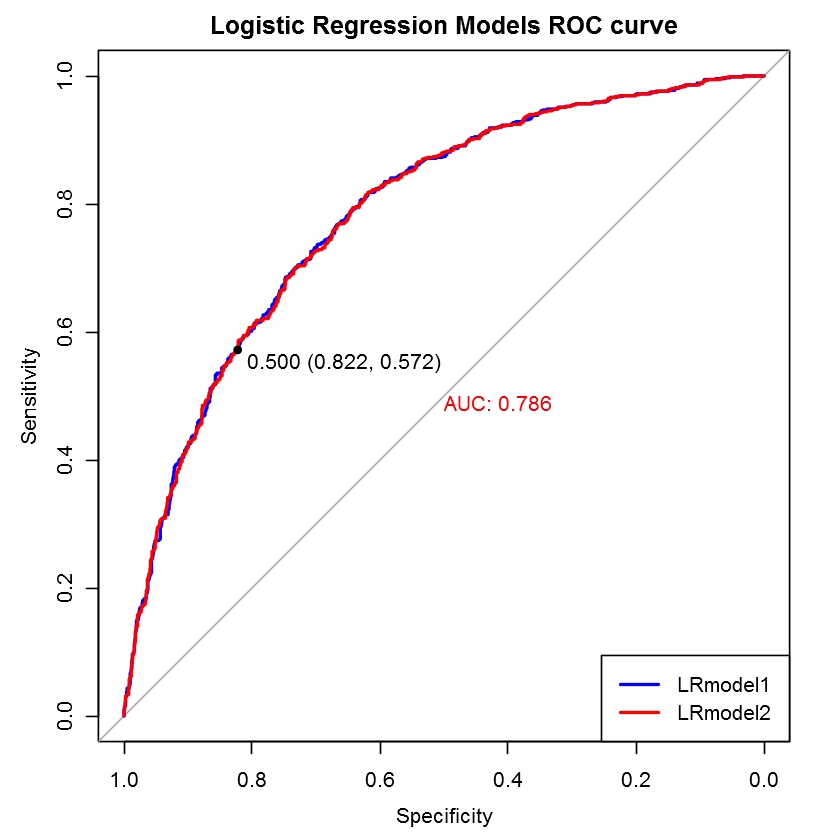

In [28]:
## Creating the ROC Curve
library(pROC)
formula1 <- as.formula("quality ~ .") 
lrmodel1 <- train(formula1, data=training, method="glm",   family=binomial(link = "logit"), preProc = c("center", "scale"), tuneLength = 5, trControl = cvCtrl)
lrProbs <- predict(lrmodel1, testing, type = "prob")

## Creating the ROC Curve
library(pROC)
lrROC <- roc(predictor = lrProbs$Good, response = testing$quality, levels = rev(levels(testing$quality)))
lrROC2 <- roc(predictor = lrProbs2$Good, response = testing$quality, levels = rev(levels(testing$quality)))

plot(lrROC, type = "S", main="Logistic Regression Models ROC curve",  col = "blue")
plot(lrROC2, add = TRUE, print.thres = .5, col = "red", print.auc=TRUE)
#plot(knnROC, add = TRUE, col = "yellow")
#plot(rfROC, add = TRUE, print.thres = .5, col = "blue", print.auc=TRUE)
legend("bottomright", legend = c("LRmodel1","LRmodel2"), col = c("blue","red"),lwd = 2)


## V Making predictions
 
After doing all the building stuff, we want to get the predictions from model2 on our training dataset.

In [29]:
# print predictions probabilities by row model2
head(as.data.frame(lrProbs2),5)

,Bad,Good
1,0.55910952,0.4408905
6,0.41961854,0.5803815
7,0.53604910,0.4639509
11,0.08677416,0.9132258
12,0.44127759,0.5587224


In [30]:
# print validation dataset and predictions by row model2
head((val<-as.data.frame(c(testing,as.data.frame(lrPred2)))),10)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,Class,lrPred2
7.0,0.27,0.36,17.55,0.045,170,3.00,0.45,8.8,Good,white,Bad
8.1,0.28,0.40,6.90,0.050,97,3.26,0.44,10.1,Good,white,Good
6.2,0.32,0.16,7.00,0.045,136,3.18,0.47,9.6,Good,white,Bad
8.1,0.27,0.41,1.45,0.033,63,2.99,0.56,12.0,Bad,white,Good
8.6,0.23,0.40,4.20,0.035,109,3.14,0.53,9.7,Bad,white,Good
7.4,0.34,0.42,1.10,0.033,171,3.12,0.53,11.3,Good,white,Good
6.5,0.31,0.14,7.50,0.044,133,3.22,0.50,9.5,Bad,white,Bad
7.0,0.25,0.32,9.00,0.046,245,3.25,0.50,10.4,Good,white,Good
7.4,0.27,0.48,1.10,0.047,132,3.19,0.49,11.6,Good,white,Good
8.5,0.24,0.39,10.40,0.044,142,3.20,0.53,10.0,Good,white,Good


Now if you want to get the predictions from a new test data, you can see the item 7.4 of my project [MACHINE LEARNING: A comparison of supervised learning algorithms applied to the classification problem with caret R-project library](http://nbviewer.jupyter.org/github/arqmain/Machine_Learning/blob/master/R_MLearning/MLearning_Classification_Comparison_R_Caret/MLearning_Classification_Comparison_R_Caret.ipynb). 

## VI Conclusion

This module of the project develops Logistic Regression algorithm of machine learning to classify the quality of the wine "Good" or "Bad" according to the 11 variables that characterize the wine subject to classification.

The database -dfffull- does not consider two variables that appear in the original base. They could generate a problem of multicollinearity in the process of classification. So,  we got rid of them in dfffull. At the same time, <u><b><i>dfffull</i></b></u> keep all the register of the original database "df" but replace the upper outliers by its corresponding <i>Threshold</i>. The application of this rule does not reduce the original data size because it does not eliminate any register. So, dfffull data size is the same as the original "df" (6497).

The lrmodel2 achieves a good classification metric, reaching ROC measurement of 80.55%. That is, the variables of the "df" database allow discriminating in a good way the quality of wine that they represent.

The model was developed selecting the variables included by using the stepwise backward elimination method based on AIC selection criterion. Anyway, this is modeling so, we can improve more or not the model by filtering other variables, using another variable selection method or doing both things at the same time.

<hr>
By: Hector Alvaro Rojas | Data Science, Visualizations and Applied Statistics | October 25, 2017<br>
Url: [http://www.arqmain.net]   &nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;   GitHub: [https://github.com/arqmain]